This notebook visualizes the average risk scores with models from the two-fold cross-validaton (five times) and plot kaplan meier curve

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob
from pathlib import Path
from lifelines import KaplanMeierFitter
sys.path.append(os.path.abspath(os.path.join('../..')))
from train_risk_regression_model_with_recon_task import get_dataset, get_model, DL_single_run

In [4]:
## initialize dataset
## 
task_name ="MI_with_HF_event"
X,y =get_dataset(dataset_name = task_name)

# ## test dummy function
# task_name ="dummy"
# X,y =get_dataset(dataset_name = task_name)

/home/engs2522/project/LLM-ECG-Dual-Attention
load signal and event data from default path
load MI_with_HF_event
load x,y from the given path /home/engs2522/project/LLM-ECG-Dual-Attention/data/ukb/MI_to_HF_survival_data/ecg_data.npy /home/engs2522/project/LLM-ECG-Dual-Attention/data/ukb/MI_to_HF_survival_data/y_status_duration.npy
input ecg shape (800, 12, 608)
status, duration, eid (800, 3)


In [5]:
## plot risk score distribution
from sklearn.model_selection import train_test_split, StratifiedKFold
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
# Initialize lists to store predictions
val_c_index_list = []
y_status_list = y[:,0]
i =0

latent_code_dim=512

In [6]:
y_status_list = y[:,0]
## here, we use models under multiple seeds to get the final prediction
seed_list = [42, 2021,2022,2023,2024]
seed_y_score_list = []
risk_scores=[]
for seed in seed_list:
    x_total_test=[]
    y_total_test=[]
    test_indices_list=[]
    total_risk_score=[]
    for cval, (train_indices, test_indices) in enumerate(kf.split(X, y_status_list)):
        x_train, y_train = X[train_indices], y[train_indices]
        x_test, y_test = X[test_indices], y[test_indices]
        ## CHANGE YOUR MODEL Path for different cross-validation here 
         ## find the best model path:
        project_root_path = Path(os.path.abspath("__file__")).parents[2]
        print(project_root_path)        
        model_dir = os.path.join(project_root_path, f"result/train_survival_net_{task_name}_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/{seed}/cval_{cval}/")
        print(model_dir)
        best_model_path_list =glob.glob(model_dir+"best_model*_lr_*.pth")
        ## remove path with alpha
        if len(best_model_path_list)==0:
            raise ValueError("No model found")
        else:
            if len(best_model_path_list) >1:
                print (best_model_path_list)

                best_model_path_list = [x for x in best_model_path_list if "alpha" not in x]
                c_index_list = [float((x.split("/")[-1]).split("_")[4]) for x in best_model_path_list]
                highest_one = np.argmax(c_index_list)
                best_model_path  = best_model_path_list[highest_one]
            else:
                best_model_path = best_model_path_list[0]
        print(best_model_path)
        trainer, survival_model = DL_single_run(x_train, y_train,  model_name = "ECG_attention",
                    batch_size = 100,
                    latent_code_dim=512,
                    train_from_scratch=True,
                    freeze_encoder=False, test_only=True, 
                    test_checkpoint_path = best_model_path, ## this is the path to the model for risk prediction
                    checkpoint_path="") ## this is the path to the pre-trained model
        survival_model.freeze()
        X_test= torch.from_numpy(x_test).float().to(survival_model.device)

        with torch.inference_mode():
            log_risk_score,_ = survival_model(X_test)

        total_risk_score.append(log_risk_score.cpu().detach().numpy())
        x_total_test.append(x_test)
        y_total_test.append(y_test)
        test_indices_list.append(test_indices)
    total_risk_score_flatten = np.concatenate(total_risk_score)
    x_total_test_flatten = np.concatenate(x_total_test)
    y_total_test_flatten = np.concatenate(y_total_test)
    test_indices_flatten = np.concatenate(test_indices_list)
    ## sort the risk score back to the original order
    risk_score_sorted = total_risk_score_flatten[np.argsort(test_indices_flatten)]
    risk_scores.append(risk_score_sorted)
    seed_y_score_list.append(risk_score_sorted)

/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_0/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_0/best_model_c_index_0.4943_lr_3.981071705534972e-07.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_1/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/42/cval_1/best_model_c_index_0.6701_lr_3.5481338923357546e-06.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2021/cval_0/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2021/cval_0/best_model_c_index_0.5874_lr_0.0031622776601683803.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2021/cval_1/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2021/cval_1/best_model_c_index_0.5479_lr_7.07945784384138e-07.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2022/cval_0/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2022/cval_0/best_model_c_index_0.6468_lr_1.1220184543019633e-06.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2022/cval_1/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2022/cval_1/best_model_c_index_0.6093_lr_4.466835921509631e-06.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2023/cval_0/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2023/cval_0/best_model_c_index_0.6478_lr_0.003981071705534974.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2023/cval_1/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2023/cval_1/best_model_c_index_0.3953_lr_6.309573444801932e-07.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2024/cval_0/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2024/cval_0/best_model_c_index_0.5656_lr_3.548133892335754e-07.pth
no linear layer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/project/LLM-ECG-Dual-Attention
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2024/cval_1/
/home/engs2522/project/LLM-ECG-Dual-Attention/result/train_survival_net_MI_with_HF_event_0.5/ECG_attention_pretrained_on_recon_ECG2Text_512/2024/cval_1/best_model_c_index_0.6407_lr_6.309573444801932e-07.pth
no linear layer


In [13]:
## average the risk score for five runs
risk_scores = np.stack(risk_scores)
print(risk_scores.shape)
risk_scores_mean = np.mean(risk_scores,axis=0)
print(risk_scores_mean.shape)

(5, 800, 1)
(800, 1)


In [14]:

## average the risk score over 5 runs
seed_y_score_list = np.stack(seed_y_score_list)
y_score = np.mean(seed_y_score_list, axis=0)
print(y_score.shape)

(800, 1)


median risk score:  5.839755058288574


/tmp/ipykernel_22075/1075921846.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_score, label="risk score distribution")


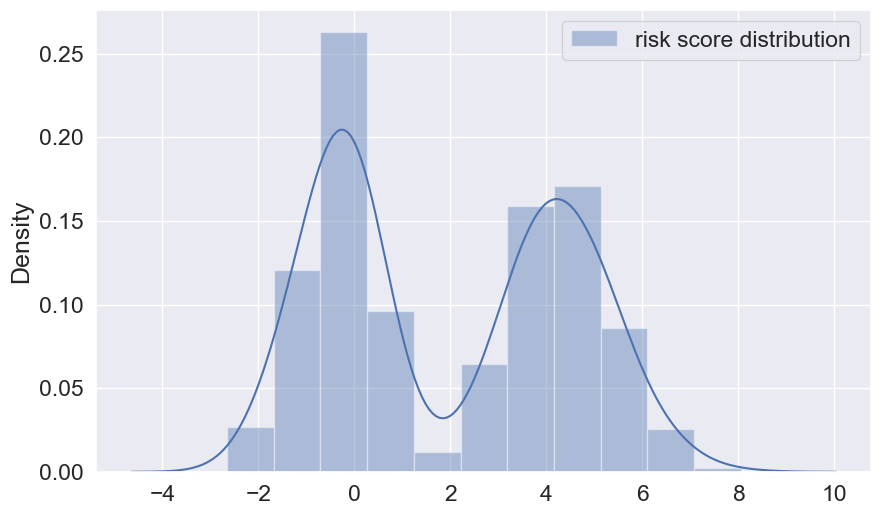

In [15]:

plt.figure(figsize=(10,6))
sns.distplot(y_score, label="risk score distribution")
plt.legend()

## find the median risk score
median_risk_score = np.median(y_score)
## find the 96% percentile risk score
if "MI" in task_name:
    median_risk_score = np.percentile(y_score, 96)
elif "HYP" in task_name:  
    median_risk_score = np.percentile(y_score, 98)

print("median risk score: ", median_risk_score)

In [16]:
high_risk_group_index = np.where(y_score>=median_risk_score)[0]
low_risk_group_index = np.where(y_score<median_risk_score)[0]

In [17]:
print("number of patients in high risk group: ", len(high_risk_group_index))
print("number of patients in low risk group: ", len(low_risk_group_index))

number of patients in high risk group:  32
number of patients in low risk group:  768


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/kaplan_meier_fitter.py:444: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/kaplan_meier_fitter.py:444: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(


(0.6, 1.01)

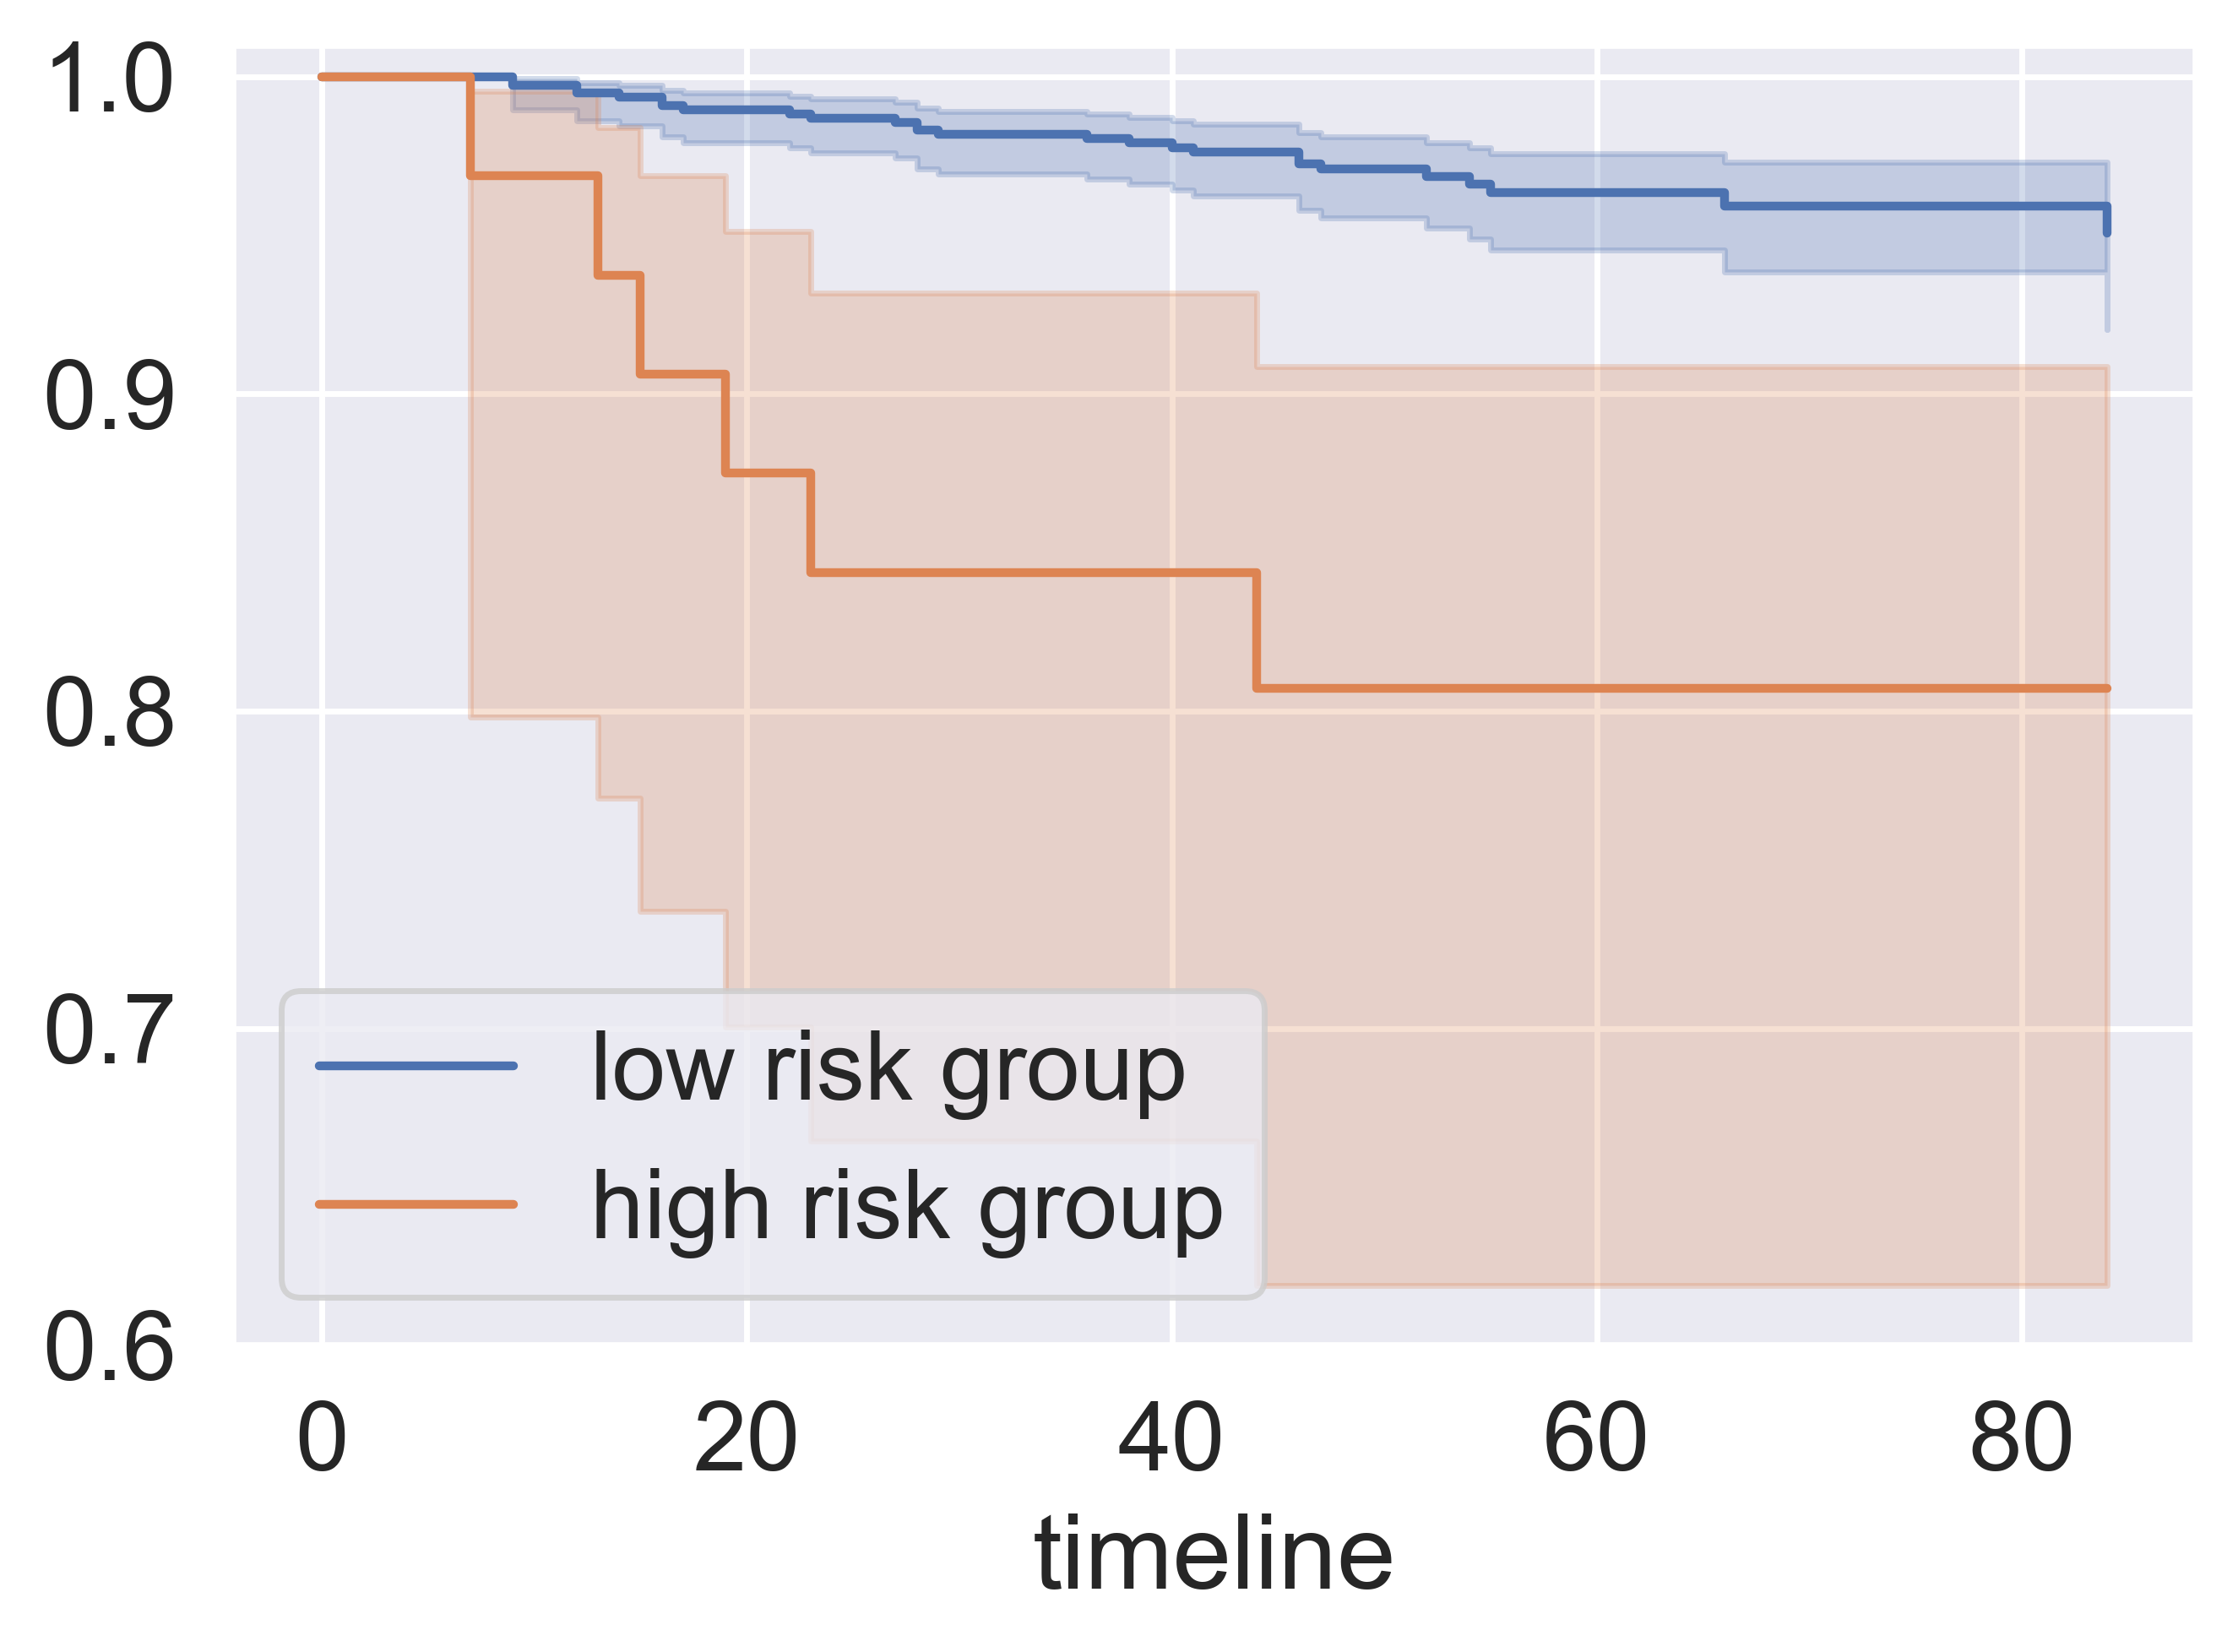

In [18]:
## plot kaplan meier curve
sns.set(font_scale=1.5)
kmf = KaplanMeierFitter()
fig, ax  = plt.subplots(1,1,figsize=(6, 4),dpi =500)
kmf.fit(y[low_risk_group_index][:,1], event_observed=y[low_risk_group_index][:,0], label="low risk group")
kmf.plot(ax=ax)
kmf.fit(y[high_risk_group_index][:,1], event_observed=y[high_risk_group_index][:,0], label="high risk group")
kmf.plot(ax=ax)

ax.set_ylim(0.60,1.01)
